# Image Classification using ResNet - American Sign Language Dataset


## Importing required packages

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils import to_categorical
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\asree\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading Data and Preprocessing

Dataset - The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion) 

<function matplotlib.pyplot.show(*args, **kw)>

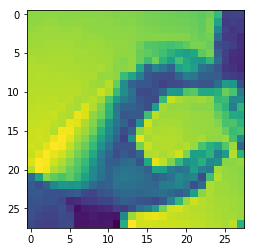

In [3]:
train = pd.read_csv('datasets/sign_mnist_train.csv')

labels = train.pop('label')
labels = to_categorical(labels)

train = train.values
train = np.reshape(train, (train.shape[0],28,28))
train = train/255

plt.imshow(train[3])
plt.show

## Splitting Training data into Train and Dev sets

In [4]:
X_train,X_dev, Y_train,Y_dev = train_test_split(train,labels,test_size= 0.2, random_state=8)
print("Training Set: " + str(X_train.shape)+ str(Y_train.shape))
print("Dev Set: " + str(X_dev.shape)+ str(Y_dev.shape))

Training Set: (21964, 28, 28)(21964, 25)
Dev Set: (5491, 28, 28)(5491, 25)


In [5]:
X_train = np.reshape(X_train,(X_train.shape[0],28,28,1))
X_dev = np.reshape(X_dev,(X_dev.shape[0],28,28,1))

## ResNet Implementation

### Identity Block

In [6]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value, to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # Second component of main path 
    X = Conv2D(filters=F2,kernel_size=(f,f), strides=(1,1),padding = 'same',name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)

    # Final step: Adding shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    return X

### Convolutional Block

In [8]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s),padding='valid',name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)    
    
    # Second component of main path 
    X = Conv2D(F2,(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b',kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3,(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3,(1,1),strides=(s,s),padding='valid',name=conv_name_base+'1',kernel_initializer= glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+'1')(X_shortcut)
    
    
    # Adding shortcut value to main path, and passing it through a RELU activation 
    
    X= Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    return X

### ModifiedResNet50 Implementation

In [9]:
def ModifiedResNet50(input_shape, classes):
    """
    Implementation of ResNet50 architecture with slight modifications:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    
    """
    
    # Input tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X,f= 3,filters= [64, 64, 256], stage=2, block='b')
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block='c')
   

    # Stage 3 
    X = convolutional_block(X,f=3,filters=[128,128,512],stage=3,block='a',s=2)
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block='b')
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block='c')
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block='d')

    # Stage 4
    X = convolutional_block(X,f=3,filters=[256,256,1024],stage=4,block='a',s=2)
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='b')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='c')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='d')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='e')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='f')


    # Stage 5
    X = convolutional_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
    X = identity_block(X,f=3,filters=[512,512,2048],stage=5,block='b')
    X = identity_block(X,f=3,filters=[512,512,2048],stage=5,block='c')

    #Can be used for bigger image sizes
    #AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D(pool_size=(2,2),name='avg_pool')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ModifiedResNet50')

    return model

In [10]:
model = ModifiedResNet50(input_shape = (28,28,1), classes = 25)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
#for running locally

In [13]:
history = model.fit(X_train, Y_train, epochs =30,batch_size = 32,validation_data=(X_dev,Y_dev))

Train on 21964 samples, validate on 5491 samples
Epoch 1/30
21964/21964 [==============================] - 70s 3ms/step - loss: 1.8774 - acc: 0.5471 - val_loss: 1.5668 - val_acc: 0.6281
Epoch 2/30
21964/21964 [==============================] - 64s 3ms/step - loss: 2.9709 - acc: 0.2302 - val_loss: 2.6043 - val_acc: 0.2708
Epoch 3/30
21964/21964 [==============================] - 65s 3ms/step - loss: 1.8469 - acc: 0.5139 - val_loss: 1.1143 - val_acc: 0.7483
Epoch 4/30
21964/21964 [==============================] - 64s 3ms/step - loss: 1.8763 - acc: 0.5415 - val_loss: 3.5522 - val_acc: 0.1843
Epoch 5/30
21964/21964 [==============================] - 65s 3ms/step - loss: 2.0318 - acc: 0.4740 - val_loss: 1.4237 - val_acc: 0.6684
Epoch 6/30
21964/21964 [==============================] - 64s 3ms/step - loss: 1.1767 - acc: 0.7369 - val_loss: 1.1501 - val_acc: 0.7521
Epoch 7/30
21964/21964 [==============================] - 65s 3ms/step - loss: 1.6994 - acc: 0.5973 - val_loss: 1.4329 - val_acc:

## Visualization

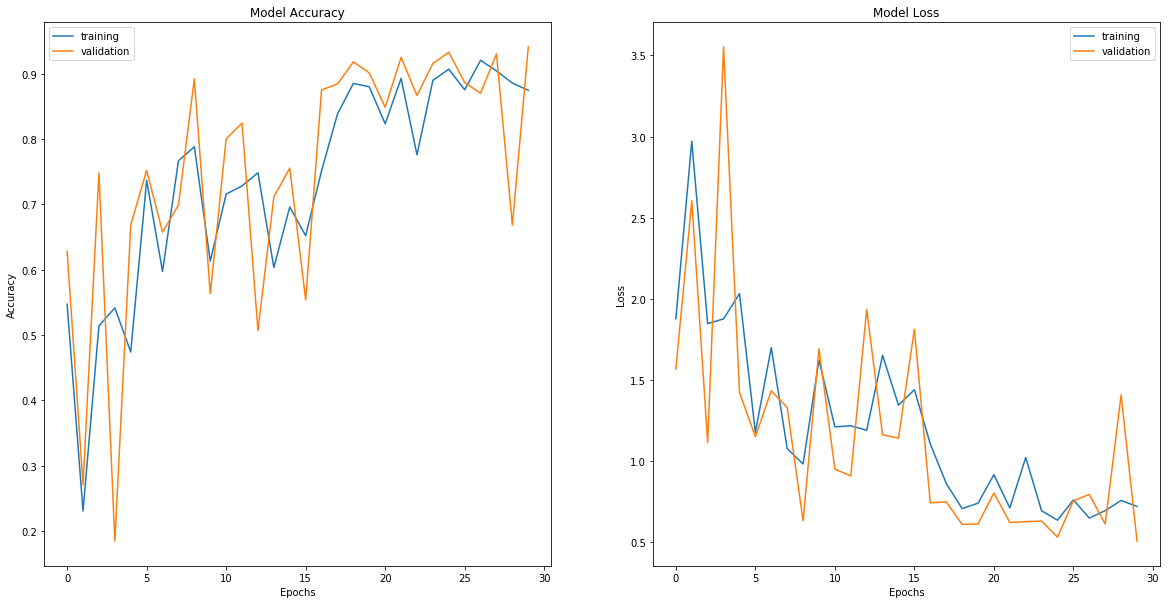

In [14]:
f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].set_title("Model Accuracy")
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(['training', 'validation'])

ax[1].set_title("Model Loss")
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(['training', 'validation'])

## Model Summary

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Testing

In [18]:
test = pd.read_csv('datasets/sign_mnist_test.csv')

labels_test = test.pop('label')
labels_test= to_categorical(labels_test)

test = test.values
#test = np.reshape(test, (test.shape[0],28,28))
test = test/255

test = np.reshape(test, (test.shape[0],28,28,1))

predictions = model.evaluate(test,labels_test)
print("Loss : " +str(predictions[0]))
print("Accuracy : " +str(predictions[1]))


(7172, 25)
(7172, 784)
7172/7172 [==============================] - 4s 604us/step
Loss : 0.2709632057221505
Accuracy : 0.9361405465699945


In [16]:
model.save_weights('model_z_weights.h5')
#Saving model weights

## References

https://www.kaggle.com/datamunge/sign-language-mnist                                                               
https://www.kaggle.com/varian97/sign-languages-recognition-using-keras/notebook                                                
https://www.coursera.org/specializations/deep-learning Deep Learning Specialization by Andrew Ng